# 0. 객체탐지(b-box) 모델을 조사
- 조사한 모델이 예상 성능 요구 사항을 충족시킬 수 있는지 확인해주세요. 확인한 내용을 **PPT 1장~3장**으로 정리해서 제출해주세요.
- 모델의 라이센스, 오픈 모델의 성능을 파악해서 왜 해당 모델을 선택했는지 작성이 되어야합니다.
- 업무요청 가이드에서는 yolov5 모델을 baseline모델로 사용하라고 되어있지만, 다른 b-box 모델을 조사했을 때 더 좋은 성능의 모델이 있다면 그 모델로 진행해도 좋습니다.


# 데이터셋 구축
- 아래의 코드 가이드를 참고해서 데이터셋 구축하는 코드를 작성해주세요
- 완료된 데이터셋 구축 코드는 **.ipynb 파일을 다운해서 제출**해주세요.

# 1. Mount google drive
- 코랩을 활용할 경우, 구글 드라이브에 있는 데이터를 사용하기 위해서 마운트 작업이 필요합니다.
- 로컬에서 진행할 경우엔 생략해주세요.
- 로컬에서 진행할 경우엔 conda를 활용하여 가상환경을 세팅해주세요.

In [1]:
#!pip install opencv-python

# 2. Import Library
- 코드에 사용되는 파이썬 라이브러리를 불러옵니다.

In [2]:
import os
import cv2
import glob
import shutil
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm # 작업 진행 속도를 보는데 유용한 라이브러리입니다.
from sklearn.model_selection import train_test_split

In [3]:
# warning 무시 코드
warnings.filterwarnings(action='ignore')

In [4]:
# 현재 실행 파일 경로 확인
os.getcwd()

'/Users/jiwonchoi/comento/1'

# 3. 데이터셋 준비
- 데이콘의 데이터셋은 차종으로 라벨링 되어 있는데, 우리는 차 종류를 객체탐지하는 것이 아닌 "차"를 객체탐지하는 것이 목표입니다.
- 차 종류로 라벨링 된 text파일 데이터를 수정해야합니다.

In [3]:
# 기존에 존재하던 데이터셋 폴더 경로 정의
origin_dir = '/Users/jiwonchoi/comento/1/dataset/row_data'

# 원본 라벨파일(.txt) 불러오기
origin_label = f'{origin_dir}/*.txt'
label_txts = glob.glob(origin_label)

# 원본 이미지파일(.png) 불러오기
origin_pic = f'{origin_dir}/*.png'
pic_txts = glob.glob(origin_pic)

print("label : ",len(label_txts), "image:",len(pic_txts))

label :  1542 image: 1542


In [6]:
label_txts[0],pic_txts[0],
label_txts[-1], pic_txts[-1]

('/Users/jiwonchoi/comento/1/dataset/row_data/syn_00186.txt',
 '/Users/jiwonchoi/comento/1/dataset/row_data/syn_01417.png')

In [7]:
# 수정된 라벨을 저장하는 폴더 경로 정의
edit_label_dir = '/Users/jiwonchoi/comento/1/dataset/data'

# 수정된 라벨링 데이터 저장 폴더를 생성
if not os.path.exists(edit_label_dir):
    os.mkdir(edit_label_dir)

# 4. Yolo 모델링을 위한 라벨링 데이터 수정
- 모든 데이터의 라벨을 "car"로 변경해야합니다.
- 기존 데이터셋의 Labelme 형태를 yolo format을 따라 라벨링 파일을 변경해야합니다.
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format


### 코드 설계 참고
- 코드를 작성하기 전에 구현하고자하는 로직을 텍스트로 설계해보는 연습도 많이 하면 좋을 것 같습니다.
1. 기존의 모든 라벨 데이터를 읽기모드로 불러와서 반복문으로 데이터 파일을 하나씩 열어줍니다.
2. 1번에서 불러온 라벨데이터(.txt)는 Labelme 형태로 <classId, x1, y1, x2, y2, x3, y3, x4, y4>에 맞게 값을 따로 정의해줍니다.
  - 참고 : strip().split(' ') 라이브러리 활용 가능
3. 모든 데이터의 라벨을 "car" 하나로만 변경해야하므로, classId는 0으로 변경해주세요
4. 2번에서 불러온 좌표값들을 활용하여 yolo 라벨 형태에 맞게 중심좌표와 너비/높이를 계산해줍니다.
5. 수정된 라벨을 새로운 파일로 저장해줍니다. (라벨 파일명은 매칭되는 이미지파일명과 동일해야합니다.)

In [8]:
# 이미지의 너비와 높이를 미리 설정하거나 각 파일에서 가져오도록 조정 필요 -> yolo label format 변경을 위함
image_file = "/Users/jiwonchoi/comento/1/dataset/row_data/syn_00002.png" #임의의 이미지파일 경로
img_height, img_width = cv2.imread(image_file).shape[0], cv2.imread(image_file).shape[1]

print('이미지 너비 : ', img_width, '\n이미지 높이 : ', img_height)

이미지 너비 :  1920 
이미지 높이 :  1040


In [9]:
import os

# 라벨 텍스트 파일 리스트 가져오기
label_txts = [os.path.join(origin_dir, file) for file in os.listdir(origin_dir) if file.endswith('.txt')]

# 원본 파일 수정 및 저장
for i in range(len(label_txts)):
    original_file_path = label_txts[i]
    new_file_path = os.path.join(edit_label_dir, os.path.basename(original_file_path))  # 새로운 폴더 경로 구성

    # 원본 파일 읽기
    with open(original_file_path, "r") as f:
        lines = f.readlines()

    # 변환 및 저장
    with open(new_file_path, "w") as f_out:  # 새 경로에 파일 저장
        for line in lines:
            values = list(map(float, line.strip().split(' ')))  # 기존 Labelme 형태 (classId, x1, y1, x2, y2, x3, y3, x4, y4)

            # 좌표 계산
            class_num = 0  # 클래스 ID를 0로 설정 ("car" 라벨 하나이기 때문에 0으로 정의)

            x_min = min(values[1], values[3], values[5], values[7])
            x_max = max(values[1], values[3], values[5], values[7])
            y_min = min(values[2], values[4], values[6], values[8])
            y_max = max(values[2], values[4], values[6], values[8])

            # 중심 좌표 및 너비/높이 계산
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            # 수정된 라벨을 파일에 기록
            f_out.write(f'{class_num} {x_center} {y_center} {width} {height}\n')
print("변환 완료")

#바꾼 경로 텍스트 파일
edit_label = f'{edit_label_dir}/*.txt'
label_txts_edit = glob.glob(edit_label)
#바꾼 경로 이미지 파일
edit_pic = f'{edit_label_dir}/*.png'
pic_txts_edit = glob.glob(edit_pic)

print("원본의 label : ",len(label_txts), "원본의 image:",len(pic_txts))
print("바꾼 경로의 label : ",len(label_txts_edit), "바꾼 경로의 image:",len(pic_txts_edit))

변환 완료
원본의 label :  1542 원본의 image: 1543
바꾼 경로의 label :  1542 바꾼 경로의 image: 0


In [10]:
# 바뀌었는지 확인
with open(new_file_path, "r") as f_out:
    lines=f_out.readline()
    print(lines)

0 0.6578125 0.4576923076923077 0.159375 0.2980769230769231



# 5. 라벨이 제대로 수정되었는지 확인하기
- 아래 함수를 통해 라벨이 제대로 수정되었는지 시각화해서 확인해주세요.
- 항상 작업을 완료후에는 결과를 확인하면서 이슈가 없는지 파악해야합니다.

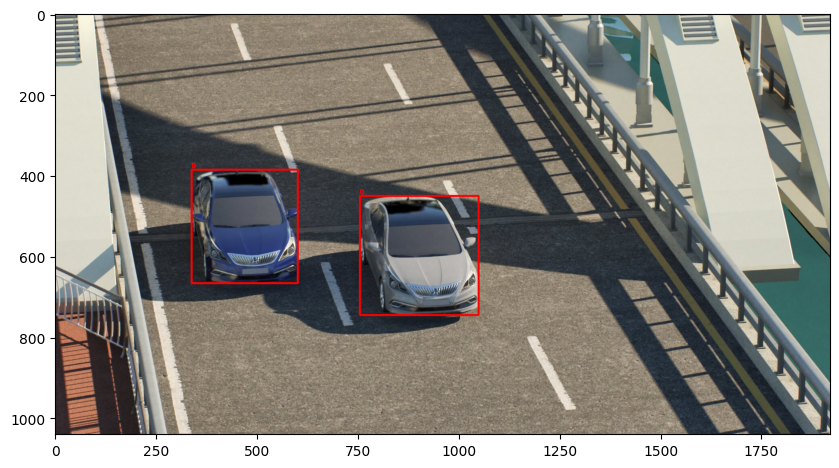

(338, 385) (601, 666)
1920 1040


In [11]:
from PIL import Image
def draw_boxes_on_image(image_path : str, annotation_path : str,
                        img_width : int, img_height : int):
    ''' 이미지와 바운딩 박스를 그리는 함수
    Args:
        image_path (str): '/content/drive/MyDrive/comento/1/dataset/row_data'
        annotation_path (str): '/content/drive/MyDrive/comento/1/dataset/data'  (.txt)
        img_width (int): 이미지의 너비
        img_height (int): 이미지의 높이
    Returns:
        show image: 이미지와 바운딩 박스가 그려진 이미지
    '''

    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])

        # YOLO 형식의 좌표를 원래 이미지 크기에 맞게 변환
        x_center = values[1] * img_width
        y_center = values[2] * img_height
        box_width = values[3] * img_width
        box_height = values[4] * img_height

        # 좌표 계산
        x_min = int(round(x_center - (box_width / 2)))
        y_min = int(round(y_center - (box_height / 2)))
        x_max = int(round(x_center + (box_width / 2)))
        y_max = int(round(y_center + (box_height / 2)))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 4)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('on')  # 축 숨기기
    plt.show()
    print((x_min, y_min), (x_max, y_max))


#### 검증 함수 실행!!
origin_dir = '/Users/jiwonchoi/comento/1/dataset/row_data'
edit_label_dir = '/Users/jiwonchoi/comento/1/dataset/data'


image_file = os.path.join(origin_dir, 'syn_00080.png')
annotation_file = os.path.join(edit_label_dir, 'syn_00080.txt')
img_width, img_height = Image.open(image_file).size

draw_boxes_on_image(image_file, annotation_file, img_width, img_height)
print(img_width, img_height)

# 6. train/valid/test set 분리
- 간단한 데이터셋 통계량 확인하고, 데이터셋 비율을 정해줍니다.
  - 차량 데이터 총 개수 확인 (참고 : glob 모듈 사용)
- 학습/검증/테스트셋 분리
  - train_test_split 라이브러리를 활용하여 test_size 인자로 데이터셋 비율을 조절할 수 있습니다. (train_test_split라이브러리는 데이터셋을 분리하는데에 많이 사용되고 있습니다.)
  - trainset : validset : testset  = 6 : 2 : 2

In [17]:
# 특정 디렉터리의 데이터 모두 확인하기
import glob

image_data= glob.glob("/Users/jiwonchoi/comento/1/dataset/row_data/*.png")
label_data= glob.glob("/Users/jiwonchoi/comento/1/dataset/data/*.txt")


print(f"차량 데이터 image 총 개수: {len(image_data)}")
print(f"차량 데이터 label 총 개수: {len(label_data)}")

차량 데이터 image 총 개수: 1542
차량 데이터 label 총 개수: 1542


In [18]:
# 학습/검증/테스트셋 분리
train_image, test_image, train_labels, test_labels =train_test_split(image_data, label_data, test_size=0.2)
train_image, valid_image, train_labels, valid_labels =train_test_split(train_image, train_labels, test_size=0.25)

# 7. 학습용 train/valid/test 데이터셋 폴더 생성

- 위에서 분리한 train/valid/testset을 옮겨둘 폴더를 생성하고, 파일을 복사해서 옮겨줍니다.
- 아래의 폴더 구조로 만들어주세요.

```
└── datasets /
    ├── images /
        ├── train /
            ├── 1.png
            ├── 2.png
        ├── val /
            ├── 3.png
            ├── 4.png
        ├── test /
            ├── 5.png
            ├── 6.png
    ├── labels /
        ├── train /
            ├── 1.txt
            ├── 2.txt
        ├── val /
            ├── 3.txt
            ├── 4.txt
        ├── test /
            ├── 5.txt
            ├── 6.txt
```

- 데이터를 저장하고자 하는 곳으로 이동 (참고 : shutil.copy 라이브러리 사용)
- 참고 자료: https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
- 구글드라이브의 용량이 부족하다면 데이터를 조금 더 삭제해서 줄여도 괜찮습니다.

In [19]:
# 데이터셋 구축 코드 작성
#1. 디렉토리 생성하기
def create_directories(base_path, sub_dirs):
    for sub_dir in sub_dirs:
        path = os.path.join(base_path, sub_dir)
        os.makedirs(path, exist_ok=True)

base_path="/Users/jiwonchoi/comento/1/datasets"
sub_dirs=["images/train","images/val","images/test","labels/train","labels/val","labels/test"]

create_directories(base_path,sub_dirs)


#2. shutil 을 이용한 이미지와 라벨 복사
def copy_files(source_files, dest_path, dataset_type):
    for file in source_files:
        try:
            shutil.copy(file, dest_path)
        except FileNotFoundError as e:
            print(f"[{dataset_type}] 파일을 찾을 수 없습니다: {e.filename}")
        except Exception as e:
            print(f"[{dataset_type}] 파일 복사 중 알 수 없는 오류 발생: {str(e)}")

# 데이터셋 파일 및 경로 설정
datasets = {
    "train": {
        "images": train_image,
        "labels": train_labels,
        "image_dest": os.path.join(base_path, "images/train"),
        "label_dest": os.path.join(base_path, "labels/train"),
    },
    "val": {
        "images": valid_image,
        "labels": valid_labels,
        "image_dest": os.path.join(base_path, "images/val"),
        "label_dest": os.path.join(base_path, "labels/val"),
    },
    "test": {
        "images": test_image,
        "labels": test_labels,
        "image_dest": os.path.join(base_path, "images/test"),
        "label_dest": os.path.join(base_path, "labels/test"),
    }
}

# 파일 복사 실행
for dataset_type, paths in datasets.items():
    copy_files(paths["images"], paths["image_dest"], dataset_type)
    copy_files(paths["labels"], paths["label_dest"], dataset_type)

# 코드 실행 완료 확인하기
print("train, val, test의 디렉토리 생성 및 데이터 복사 완료")

train, val, test의 디렉토리 생성 및 데이터 복사 완료


In [20]:
image_t= glob.glob("/Users/jiwonchoi/comento/1/datasets/images/train/*.png")
label_t= glob.glob("/Users/jiwonchoi/comento/1/datasets/labels/train/*.txt")

print(f"차량 데이터 image - train: {len(image_t)}, label - train: {len(label_t)}")

차량 데이터 image - train: 924, label - train: 924



- 학습에 사용되는 .yaml 파일을 아래 형식에 맞춰서 만들어줍니다.

```
names:
- car
nc: 1
path: "dataset_folder_root_path"
test: "test_image_dataset_folder_path"
train: "train_image_dataset_folder_path"
val: "validation_image_dataset_folder_path"
```

In [21]:
import yaml
paa="/Users/jiwonchoi/comento/1/datasets"
# 데이터 구성
cardata = {
    "names": ["car"],  # 클래스 이름
    "nc": 1,           # 클래스 수
    "path": paa,  # 루트 경로
    "train": paa +"/images/train",  # 학습 데이터 경로
    "val": paa+ "/images/val",  # 검증 데이터 경로
    "test": paa+"/images/test",      # 테스트 데이터 경로
}

In [22]:
# YAML 파일 저장
yaml_path = "/Users/jiwonchoi/comento/1/datasets/cardata.yaml"
with open(yaml_path, 'w') as f:
    yaml.dump(cardata, f)

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# 내용 출력
print(data, end='\n')

{'names': ['car'], 'nc': 1, 'path': '/Users/jiwonchoi/comento/1/datasets', 'test': '/Users/jiwonchoi/comento/1/datasets/images/test', 'train': '/Users/jiwonchoi/comento/1/datasets/images/train', 'val': '/Users/jiwonchoi/comento/1/datasets/images/val'}
